In [1]:
import pandas as pd
from transformers import pipeline
import os
import statistics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# tested the following pretrained sentiment analysis LLMs
fineautomatabertweet = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")  # found this one to work the best
lxyuandistilbert = pipeline(model="lxyuan/distilbert-base-multilingual-cased-sentiments-student")
prosusaifinbert = pipeline(model="ProsusAI/finbert")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu
Device set to use cpu
Device set to use cpu


In [3]:
models = ["fineautomatabertweet",
"lxyuandistilbert",
"prosusaifinbert"]

In [4]:
transcripts_dir = "simulated_transcripts/" # location of the simulated call transcripts
text_files = [transcripts_dir+filename for filename in os.listdir(transcripts_dir) if filename.endswith(".txt")] # make a list of transcripts

In [5]:
def extract_member_lines(file_path):
    """
    Given a path to a simulated transcript, create a dataframe containing the lines from the "Member" side of the conversation,
    with the "Member: " labelled removed from the beginning of the line.
    """
    member_lines = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("Member: "):
                # Append the line without the "Member: " part to the list
                member_lines.append(line[len("Member: "):].strip())
    df = pd.DataFrame(member_lines, columns=['Member_Line'])
    return df

def process_member_lines_with_model(df, specific_model):
    """
    Given a dataframe of the member side of the conversation, generated by extract_member_lines, and a model 
    specified at the beginning of the script, test the sentiment of the call.
    """
    # List to store the results
    results = []

    # Iterate through each row in the dataframe
    for _, row in df.iterrows():
        # Get the Member_Line from the row (ensure it's a string)
        member_line = row['Member_Line']
        
        # Pass the line to the specific_model function
        model_results = specific_model(member_line)

    return model_results

def evaluate_model(directory, model_choice):
    """
    Evaluates resolution classification across all files in the given directory and using the given model choice.
    Choose from 'fineautomatabertweet', 'lxyuandistilbert', 'prosusaifinbert'
    """
    true_labels = []
    predicted_labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)

            parts = filename.lower().split('_')     # split the filename by underscores so the known sentiment can be extracted
            if "negative" in parts:
                true_label = "negative"
            elif "neutral" in parts:
                true_label = "neutral"
            elif "positive" in parts:
                true_label = "positive"
            else:
                raise ValueError(f"Resolution status not found in filename: {filename}")            

            true_labels.append(true_label)
            
            a = extract_member_lines(file_path)
            line_sentiment=[]
         
            for i in range(len(a)):
                model_choice = fineautomatabertweet
                line_result=model_choice(a['Member_Line'].iloc[i])
                line_score=line_result[0]['score']
            
                if line_score > 0.9:
                    line_sentiment.append(line_result[0]['label'])
    
            if not line_sentiment:
                predicted_labels.append("undetermined")
            else:    
                predicted_labels.append(statistics.mode(line_sentiment))
    
    # strings to check
    targets = ["POS", "NEG", "NEU"]
    
    # check that the labels are there presence
    found = [item for item in targets if item in predicted_labels]

    # some models produce slightly different outputs, account for that by mapping these values
    mapping = {"POS": "positive", "NEU": "neutral", "NEG": "negative"}

    if found:
        # apply the mapping
        predicted_labels_remap = [mapping.get(value, value) for value in predicted_labels]
        return true_labels, predicted_labels_remap  # if necessary, return the remapped predicted labels
    else:
        return true_labels, predicted_labels # otherwise just return the original predicted labels

In [6]:
true_list,predict_list = evaluate_model(transcripts_dir, fineautomatabertweet)   # run the evaluation

In [7]:
undetermined_indices = [index for index, value in enumerate(predict_list) if value == "undetermined"]
filtered_predictions = [value for index, value in enumerate(predict_list) if index not in undetermined_indices]
filtered_trues = [value for index, value in enumerate(true_list) if index not in undetermined_indices]

valid_classes = ["positive", "negative", "neutral"]

# calculate metrics
print("Classification Report:")
print(classification_report(filtered_trues, filtered_predictions, target_names=valid_classes))

cm = confusion_matrix(filtered_trues, filtered_predictions, labels=valid_classes)
accuracy = accuracy_score(filtered_trues, filtered_predictions)

print(f"Accuracy: {accuracy:.2f}")

Classification Report:
              precision    recall  f1-score   support

    positive       0.90      0.95      0.93        20
    negative       0.78      0.90      0.84        20
     neutral       1.00      0.80      0.89        20

    accuracy                           0.88        60
   macro avg       0.90      0.88      0.88        60
weighted avg       0.90      0.88      0.88        60

Accuracy: 0.88


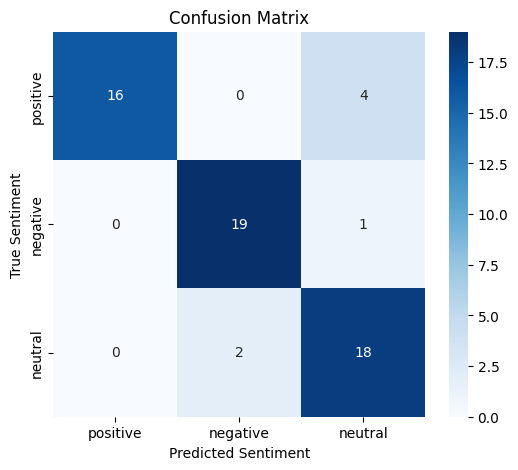

In [8]:
# plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=valid_classes, yticklabels=valid_classes)
plt.xlabel("Predicted Sentiment")
plt.ylabel("True Sentiment")
plt.title("Confusion Matrix")

#plt.savefig('confusion_matrix_sentiment.png', dpi=300, bbox_inches='tight')  # uncomment to save the confusion matrix

plt.show()

In [9]:
# print a list of files where the classification failes
mismatched_indices = [i for i in range(len(predict_list)) if predict_list[i] != true_list[i]]
for index in mismatched_indices:
    print(text_files[index], predict_list[index])

labelled_transcripts_2/negative_resolved_9.txt neutral
labelled_transcripts_2/neutral_resolved_1.txt negative
labelled_transcripts_2/neutral_resolved_4.txt negative
labelled_transcripts_2/positive_notresolved_1.txt neutral
labelled_transcripts_2/positive_notresolved_2.txt neutral
labelled_transcripts_2/positive_resolved_7.txt neutral
labelled_transcripts_2/positive_resolved_8.txt neutral
